<a href="https://colab.research.google.com/github/vanyalzr/spike_data_generation/blob/master/generate_spike_raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! apt install build-essential git python3-dev python3-setuptools python3-scipy python3-matplotlib python3-sympy cython3

In [0]:
! apt install python3-pyqtgraph python3-pyqt4.qtopengl python3-lxml # optional

In [0]:
pip install ANNarchy

In [0]:
import numpy as np
import pandas as pd

import ANNarchy as ann
from ANNarchy import Population
from ANNarchy import Projection
from ANNarchy import Monitor
from ANNarchy import Izhikevich
from ANNarchy import Uniform


class SpikingNet:
    def __init__(
        self,
        n_neurons,
        parameters,
        noise,
        e_neurons=800,
        i_neurons=200,
        e_weight_max=0.5,
        i_weight_max=1.0,
    ):

        ann.clear()

        self.n_neurons = n_neurons
        self.parameters = parameters
        self.parameters['noise'] = noise
        self.e_neurons = e_neurons
        self.i_neurons = i_neurons
        self.e_weight_max = e_weight_max
        self.i_weight_max = i_weight_max
        self.total_neurons = self.n_neurons + self.e_neurons + self.i_neurons
        self.re = np.random.random(self.e_neurons)
        self.exc_parameters = {
            'noise': 5.0,
            'a': 0.02,
            'b': 0.2,
            'c': -65.0 + 15.0 * self.re ** 2,
            'd': 8.0 - 6.0 * self.re ** 2,
        }
        self.ri = np.random.random(self.i_neurons)
        self.inh_parameters = {
            'noise': 2.0,
            'a': 0.02 + 0.08 * self.ri,
            'b': 0.25 - 0.05 * self.ri,
            'c': -65.0,
            'd': 2.0,
        }

        self.construct()

    def set_population_parameters(self, population, parameters):

        population.noise = parameters['noise']
        population.a = parameters['a']
        population.b = parameters['b']
        population.c = parameters['c']
        population.d = parameters['d']
        if 'v' in parameters:
            population.v = parameters['v']
        else:
            population.v = -65.0

        population.u = population.v * population.b

    def construct(self):

        population = Population(geometry=self.total_neurons, neuron=Izhikevich)
        exc_pop = population[: self.e_neurons]
        inh_pop = population[self.e_neurons : (self.e_neurons + self.i_neurons)]
        custom_pop = population[(self.e_neurons + self.i_neurons) : self.total_neurons]

        self.set_population_parameters(exc_pop, self.exc_parameters)
        self.set_population_parameters(inh_pop, self.inh_parameters)
        self.set_population_parameters(custom_pop, self.parameters)

        exc_proj = Projection(pre=exc_pop, post=population, target='exc')
        exc_proj.connect_all_to_all(weights=Uniform(0.0, self.e_weight_max))

        inh_proj = Projection(pre=inh_pop, post=population, target='inh')
        inh_proj.connect_all_to_all(weights=Uniform(0.0, self.i_weight_max))

        ann.compile()

        self.monitor = Monitor(population, ['spike', 'v'])

    def run(self, time=1000):

        ann.simulate(time, measure_time=True)

        spikes = self.monitor.get('spike')
        v = self.monitor.get('v')
        t, n = self.monitor.raster_plot(spikes)
        fr = self.monitor.histogram(spikes)

        neurons_custom = n[np.where(n > (self.total_neurons - self.n_neurons))[0]]
        t_custom = t[np.where(n > (self.total_neurons - self.n_neurons))[0]]
        t_initial_transient = 0
        t_custom = t_custom[np.where(t_custom > t_initial_transient)[0]]
        neurons_custom = neurons_custom[np.where(t_custom > t_initial_transient)[0]]
        mean_firing_rate = (
            np.mean(pd.Series(neurons_custom).value_counts().values) / time * 1000
        )

        return t_custom, neurons_custom, mean_firing_rate

In [0]:
def process_raster(times, neurons):

    raster = pd.DataFrame()
    raster['neuron'] = neurons
    raster['times'] = times

    trains = []
    isi_series = []
    isis = []

    for neuron_id in raster['neuron'].value_counts().index.values:
        train = raster[raster['neuron'] == neuron_id]['times'].values
        isi_series.append(np.diff(train))
        isis += list(np.diff(train))
        trains.append(train)

    return trains, isi_series, isis


def save_isis_to_file(isi_series_list, file):

    with open(file, 'w') as outfile:
        for isi_series in isi_series_list:
            outfile.write(', '.join(list(map(str, isi_series))))
            outfile.write('\n')

In [0]:
regular_spiking_params = {'a': 0.02, 'b': 0.2, 'c': -65.0, 'd': 8.0, 'v': -60}

rs_net = SpikingNet(n_neurons=100,
                    parameters=regular_spiking_params,
                    noise=3.9,
                    e_neurons=2,
                    i_neurons=2,
                    e_weight_max=0,
                    i_weight_max=0)


rs_times, rs_neurons, rate = rs_net.run(time=1e3)
_, rs_isis, rs_isi = process_raster(rs_times, rs_neurons)

Simulating 1.0 seconds of the network took 0.009318828582763672 seconds. 


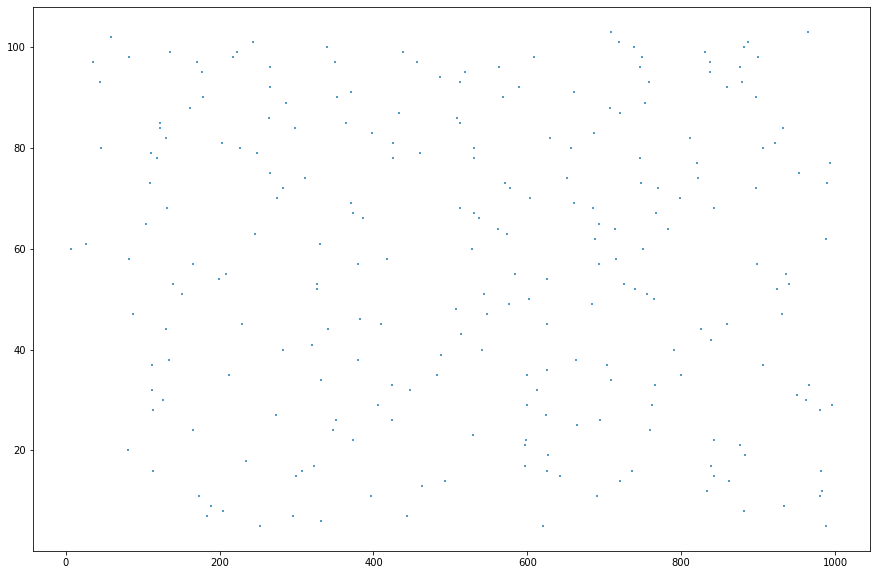

In [0]:
import matplotlib.pyplot as plt


plt.scatter(rs_times, rs_neurons, s=3.0, marker='|')
plt.rcParams['figure.figsize'] = 15, 10